In [1]:
## import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
from datetime import datetime
from dateutil.relativedelta import relativedelta


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.regression.linear_model import OLS

# ploting initiation
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [2]:
## data extraction
zip_path = "Data-20240401.zip"

with zipfile.ZipFile(zip_path, 'r') as zip:
    zip.extractall(path='data/')

FF5 = pd.read_csv('data/FF5_2000_2022.csv')
CRSP = pd.read_csv('data/CRSP_2000_2022.csv')
PS = pd.read_csv('data/PS_2000_2022.csv')
HXZ5 = pd.read_csv('data/HXZ5_2000_2022.csv')

In [3]:
CRSP.tail()
# CRSP.loc[CRSP['PERMNO'] == 10324]
# PERMNO: unique identifier for each stock
# MthPrc: monthly price
# MthRet: monthly total return

,PERMNO,YYYYMM,MthPrc,MthRet
82055,93436,202208,275.61,-0.072489
82056,93436,202209,265.25,-0.037589
82057,93436,202210,227.54,-0.142168
82058,93436,202211,194.70,-0.144326
82059,93436,202212,123.18,-0.367334


In [4]:
FF5.tail()
# FF5.describe()
# Mkt-RF: excess return on the market
# SMB: (Small Minus Big) is the average return on the nine small stock portfolios minus the average return on the nine big stock portfolios
# HML: (High Minus Low) is the average return on the two value portfolios minus the average return on the two growth portfolios
# RMW: (Robust Minus Weak) is the average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios,
# CMA: (Conservative Minus Aggressive) is the average return on the two conservative investment portfolios minus the average return on the two aggressive investment portfolios,

,YYYYMM,Mkt-RF,SMB,HML,RMW,CMA,RF
271,202208,-3.77,1.51,0.31,-4.80,1.30,0.19
272,202209,-9.35,-1.00,0.03,-1.50,-0.85,0.19
273,202210,7.83,1.87,8.05,3.07,6.56,0.23
274,202211,4.60,-2.68,1.39,6.02,3.11,0.29
275,202212,-6.41,-0.13,1.36,0.08,4.18,0.33


In [5]:
HXZ5.tail()
# HXZ5.describe()
# R_ME: the size factor returns
# R_IA: the investment factor returns
# R_ROE: the return on equity factor returns
# R_EG: the expected growth factor returns.

,R_F,R_MKT,R_ME,R_IA,R_ROE,R_EG,YYYYMM
271,0.1901,-3.7735,1.4291,2.7381,-2.7978,-3.5470,202208
272,0.1929,-9.3458,-1.6943,-0.2182,1.1517,1.7172,202209
273,0.2327,7.8326,4.6904,7.4110,5.3826,-0.9359,202210
274,0.2856,4.6082,-2.3226,2.1779,2.3981,1.2883,202211
275,0.3379,-6.4054,0.2797,3.8672,-0.5108,-0.3618,202212


In [6]:
PS.tail()
# PS.describe()
# AggLiq: Aggregate liquidity level
# eq8: Innovations in aggregated liquidity
# LIQ_V: Traded liquidity factor

,YYYYMM,AggLiq,eq8,LIQ_V
259,202108,0.012418,0.032290,0.003736
260,202109,-0.016866,-0.006602,-0.012899
261,202110,-0.006214,-0.008326,0.015679
262,202111,0.014166,0.030774,-0.026395
263,202112,0.060568,0.070741,-0.023452


In [7]:
## Data preparation

# stock return
CRSP['date'] = pd.to_datetime(CRSP['YYYYMM'], format='%Y%m')
ret_data = CRSP.set_index('date').drop(['YYYYMM','MthPrc'],axis=1)

# factors
factors_data = (FF5
            .merge(HXZ5, on='YYYYMM')
            .merge(PS, on='YYYYMM',how='left')
            .drop(columns=['R_MKT','R_F','RF'])
)
factors_data['date'] = pd.to_datetime(factors_data['YYYYMM'], format='%Y%m')
factors_data = factors_data.set_index('date').drop('YYYYMM',axis=1)

# name of factors
exog_vars = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'R_ME', 'R_IA', 'R_ROE', 'R_EG', 'AggLiq', 'eq8', 'LIQ_V']

# whole dataframe
df = ret_data.merge(factors_data,how='left',on='date')
df_filtered = df.groupby('PERMNO').filter(lambda x: len(x) > 60)

# 1 (Navie) Factor Regression
rolling-window regression:$$R_{i,t} = \alpha + \sum \beta_{i,j} F_{j,t} + \varepsilon_{i,t}$$

In [8]:
## Rolling window regression for the eligible stocks
# Data preparation
y = df.loc[df['PERMNO'] == 10324, ['MthRet']]
exog = sm.add_constant(df.loc[df['PERMNO'] == 10324, exog_vars])

# Regression
rres = RollingOLS(y['MthRet'], exog, window=60).fit()

# parameters
# params = rres.params.copy()
# params

Text(0.5, 1.0, 'Mkt-RF (PERMNO = 10324)')

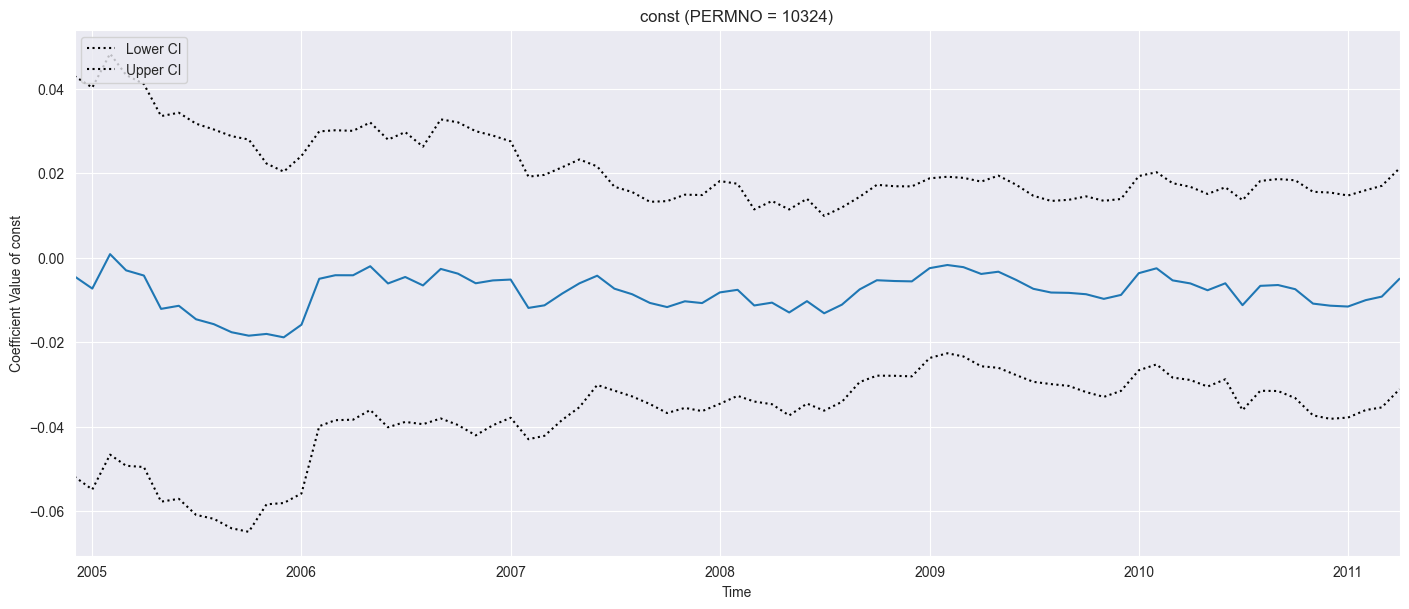

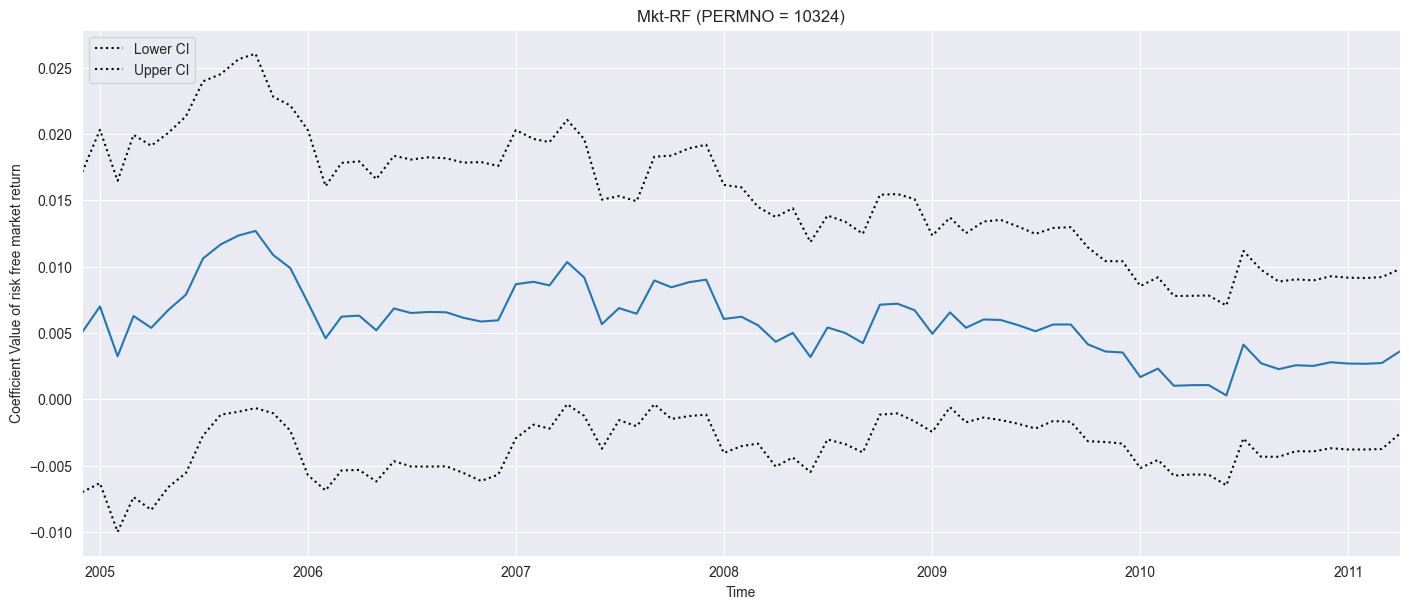

In [9]:
## time series plot and 95% CI of const and risk free market return
fig = rres.plot_recursive_coefficient(variables=['const'], figsize=(14, 6))
plt.ylabel('Coefficient Value of const')
plt.xlabel('Time')
plt.title('const (PERMNO = 10324)')
fig.savefig('const_naive_coeff.png')

fig = rres.plot_recursive_coefficient(variables=['Mkt-RF'], figsize=(14, 6))
plt.ylabel('Coefficient Value of risk free market return')
plt.xlabel('Time')
plt.title('Mkt-RF (PERMNO = 10324)')
#fig.savefig('fig/mktrf_naive_coeff.png')

# 2 Fama-MacBeth Regression

In [10]:
## first stage time series reg
stocks = df_filtered['PERMNO'].unique()
params = pd.DataFrame()
for stock in stocks:
    y = df.loc[df['PERMNO'] == stock, ['MthRet']]
    exog = sm.add_constant(df.loc[df['PERMNO'] == stock, exog_vars])
    rres = RollingOLS(y['MthRet'], exog, window=60).fit()
    param_temp = rres.params
    param_temp['PERMNO'] = stock
    params = pd.concat([params, param_temp])


In [11]:
# data preparation for cross-sectional reg
beta = params.drop(columns='const')
y = df_filtered[['PERMNO','MthRet']]
temp = y.set_index('PERMNO', append=True).swaplevel()
fmdata = (pd.merge(temp.dropna().reset_index(),beta.reset_index(),on=['PERMNO','date'])
            .set_index('date')
            .dropna()
            .reset_index()
            .sort_values(['date'])
)
months = fmdata['date'].unique()

In [12]:
## second stage cross-sectional reg
gamma = pd.DataFrame()
for mon in months:
    y = fmdata.loc[fmdata['date']==mon,'MthRet']
    exog = sm.add_constant(fmdata.loc[fmdata['date']==mon, exog_vars])
    rres = OLS(y, exog).fit()
    temp = rres.params
    temp.name = mon
    gamma = pd.concat([gamma, temp],axis=1)

gamma = np.transpose(gamma)

C:\Users\ly0001\AppData\Local\Temp\ipykernel_11384\3101323842.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  gamma = pd.concat([gamma, temp],axis=1)


Text(0.5, 1.0, "Mkt-RF's risk premium, 2005-2022")

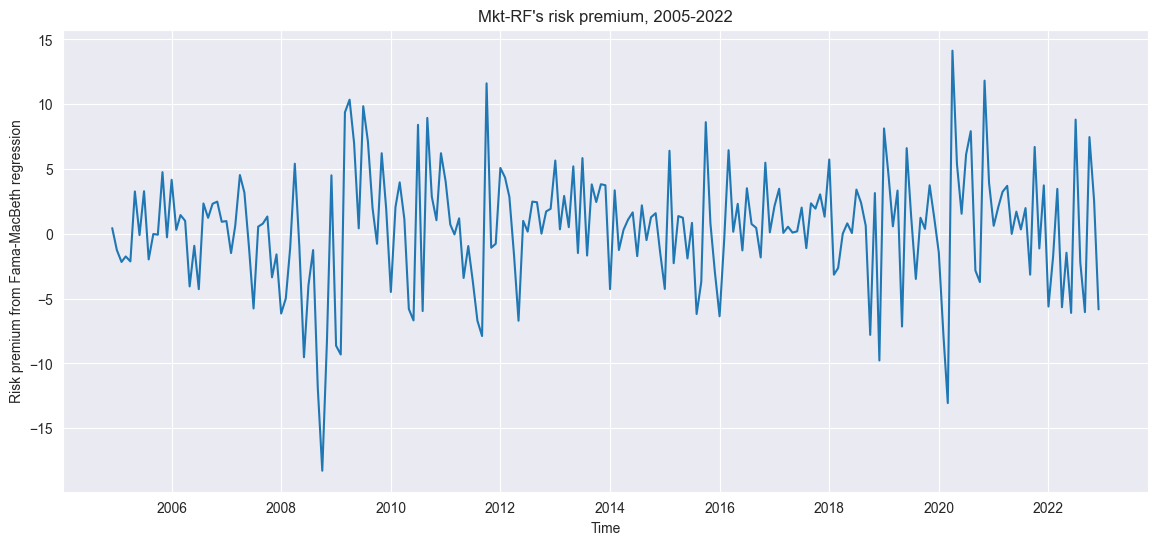

In [13]:
## visualization
fig = plt.figure(figsize=(14, 6))
plt.plot(gamma.index, gamma['Mkt-RF'])
plt.xlabel('Time')
plt.ylabel('Risk premium from Fama-MacBeth regression')
plt.title("Mkt-RF's risk premium, 2005-2022")
#fig.savefig('fig/mktrf_fm_riskp.png')

# 3 LASSO Regression

In [54]:
## Data preparation
# Create lags
lag_periods = range(1,7)  # Lag periods from 0 to 6 months
exog_vars_LASSO = exog_vars

# Iterate over each factor column
df_LASSO = df_filtered
columns = df_LASSO.columns
for column in columns:
    if column not in ['PERMNO','MthRet']:  # Exclude the 'YYYYMM' column
        # Create lagged columns for each lag period
        for lag in lag_periods:
            df_LASSO[f'{column}_l{lag}'] = df_LASSO[column].shift(lag)
            exog_vars_LASSO.append(f'{column}_l{lag}')

# date list
datelist = pd.date_range('2005-1-1','2020-1-1',freq='YS').tolist()

# data for LASSO
df_LASSO = df_LASSO.reset_index(drop=False)
df_LASSO_1 = df_LASSO
print(df_LASSO_1.head())

C:\Users\ly0001\AppData\Local\Temp\ipykernel_11384\1758829028.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_LASSO[f'{column}_l{lag}'] = df_LASSO[column].shift(lag)
C:\Users\ly0001\AppData\Local\Temp\ipykernel_11384\1758829028.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_LASSO[f'{column}_l{lag}'] = df_LASSO[column].shift(lag)
C:\Users\ly0001\AppData\Local\Temp\ipykernel_11384\1758829028.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

        date  PERMNO    MthRet  Mkt-RF    SMB   HML    RMW   CMA     R_ME  \
0 2000-01-01   10324  0.155556   -4.74   4.44 -1.91  -6.31  4.75   5.6171   
1 2000-02-01   10324  0.104567    2.45  18.34 -9.70 -18.73 -0.36  22.1445   
2 2000-03-01   10324 -0.127312    5.20 -15.35  8.17  11.82 -1.65 -14.4020   
3 2000-04-01   10324 -0.026185   -6.40  -5.01  7.26   7.66  5.65  -4.8609   
4 2000-05-01   10324  0.163892   -4.42  -3.84  4.81   4.17  1.30  -4.5950   

     R_IA  ...  LIQ_V_l6_l5_l3  LIQ_V_l6_l5_l4  LIQ_V_l6_l5_l5  \
0  2.9355  ...             NaN             NaN             NaN   
1 -5.3931  ...             NaN             NaN             NaN   
2  1.8350  ...             NaN             NaN             NaN   
3  3.7873  ...             NaN             NaN             NaN   
4  0.5085  ...             NaN             NaN             NaN   

   LIQ_V_l6_l5_l6  LIQ_V_l6_l6_l1  LIQ_V_l6_l6_l2  LIQ_V_l6_l6_l3  \
0             NaN             NaN             NaN             NaN   
1 

In [15]:
## simple LASSO
window = 60
alpha = 0.01
error=pd.DataFrame()
params=pd.DataFrame()
for date in datelist:
    start_date = date + relativedelta(months=-window)
    for stock in stocks:
        df_temp = df_LASSO.loc[(df_LASSO['PERMNO'] == stock) & ((df_LASSO['date'] <= date) & (df_LASSO['date'] > start_date))].dropna()
        y = df_temp['MthRet']
        X = df_temp[exog_vars_LASSO]
        try:
            rres = Lasso(alpha=alpha).fit(X,y)
            temp_params = rres.coef_
            temp_params = pd.DataFrame(temp_params.reshape(-1,len(temp_params)),columns=exog_vars_LASSO)
            temp_params['date'] = date
            temp_params['PERMNO'] = stock
            params = pd.concat([params,temp_params])
        except:
            temp_error = pd.DataFrame({'date':date,'PERMNO':stock},index=[0])
            error = pd.concat([error,temp_error])
params = params.set_index('PERMNO')

C:\Users\ly0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\ly0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\ly0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\l

In [16]:
## top 5 factors each period
# aggregation by period
para = params.groupby('date').agg(lambda x: np.count_nonzero(x)).reset_index(drop=False)
para

# top 5 factors
params_star = pd.DataFrame()
for date in datelist:
    temp = para.loc[para['date'] == date]
    temp = temp.drop(columns='date').sort_values(by=temp.index.values[0],axis=1,ascending=False).columns[:5].values
    temp = pd.DataFrame(temp).T
    temp['date'] = date
    params_star = pd.concat([params_star,temp],axis=0)
params_star = params_star.set_index('date')
params_star.columns=['1st','2nd','3rd','4th','5th']
params_star

,1st,2nd,3rd,4th,5th
date,,,,,
2005-01-01,Mkt-RF,HML,Mkt-RF_l5,HML_l3,Mkt-RF_l4
2006-01-01,Mkt-RF,Mkt-RF_l2,HML,Mkt-RF_l5,Mkt-RF_l4
2007-01-01,Mkt-RF,R_ME,SMB,Mkt-RF_l3,Mkt-RF_l1
2008-01-01,Mkt-RF,Mkt-RF_l2,SMB,Mkt-RF_l1,HML
2009-01-01,Mkt-RF,Mkt-RF_l3,HML,Mkt-RF_l1,Mkt-RF_l4
2010-01-01,Mkt-RF,Mkt-RF_l4,Mkt-RF_l1,Mkt-RF_l2,Mkt-RF_l3
2011-01-01,Mkt-RF,Mkt-RF_l1,Mkt-RF_l4,Mkt-RF_l2,HML
2012-01-01,Mkt-RF,Mkt-RF_l2,Mkt-RF_l4,Mkt-RF_l1,Mkt-RF_l3
2013-01-01,Mkt-RF,Mkt-RF_l4,Mkt-RF_l2,Mkt-RF_l1,Mkt-RF_l3


In [17]:
'''
# LASSO with cross validation
window = 60
alpha = 0.001
error=pd.DataFrame()
params=pd.DataFrame()
for date in datelist:
    start_date = date + relativedelta(months=-window)
    for stock in stocks:
        df_temp = df_LASSO.loc[(df_LASSO['PERMNO'] == stock) & ((df_LASSO['date'] <= date) & (df_LASSO['date'] > start_date))].dropna()
        y = df_temp['MthRet']
        X = df_temp[exog_vars_LASSO]
        try:
            rres = LassoCV(cv=5,eps=1e-4).fit(X,y)
            temp_params = rres.coef_
            temp_params = pd.DataFrame(temp_params.reshape(-1,len(temp_params)),columns=exog_vars_LASSO)
            temp_params['date'] = date
            temp_params['PERMNO'] = stock
            params = pd.concat([params,temp_params])
        except:
            temp_error = pd.DataFrame({'date':date,'PERMNO':stock},index=[0])
            error = pd.concat([error,temp_error])
params = params.set_index('PERMNO')
'''

"\n# LASSO with cross validation\nwindow = 60\nalpha = 0.001\nerror=pd.DataFrame()\nparams=pd.DataFrame()\nfor date in datelist:\n    start_date = date + relativedelta(months=-window)\n    for stock in stocks:\n        df_temp = df_LASSO.loc[(df_LASSO['PERMNO'] == stock) & ((df_LASSO['date'] <= date) & (df_LASSO['date'] > start_date))].dropna()\n        y = df_temp['MthRet']\n        X = df_temp[exog_vars_LASSO]\n        try:\n            rres = LassoCV(cv=5,eps=1e-4).fit(X,y)\n            temp_params = rres.coef_\n            temp_params = pd.DataFrame(temp_params.reshape(-1,len(temp_params)),columns=exog_vars_LASSO)\n            temp_params['date'] = date\n            temp_params['PERMNO'] = stock\n            params = pd.concat([params,temp_params])\n        except:\n            temp_error = pd.DataFrame({'date':date,'PERMNO':stock},index=[0])\n            error = pd.concat([error,temp_error])\nparams = params.set_index('PERMNO')\n"

In [18]:

'''## top 5 factors each period
# aggregation by period
para = params.groupby('date').agg(lambda x: np.count_nonzero(x)).reset_index(drop=False)
para

# top 5 factors
params_star = pd.DataFrame()
for date in datelist:
    temp = para.loc[para['date'] == date]
    temp = temp.drop(columns='date').sort_values(by=temp.index.values[0],axis=1,ascending=False).columns[:5].values
    temp = pd.DataFrame(temp).T
    temp['date'] = date
    params_star = pd.concat([params_star,temp],axis=0)
params_star = params_star.set_index('date')
params_star.columns=['1st','2nd','3rd','4th','5th']
params_star
'''

,1st,2nd,3rd,4th,5th
date,,,,,
2005-01-01,Mkt-RF,HML,Mkt-RF_l5,HML_l3,Mkt-RF_l4
2006-01-01,Mkt-RF,Mkt-RF_l2,HML,Mkt-RF_l5,Mkt-RF_l4
2007-01-01,Mkt-RF,R_ME,SMB,Mkt-RF_l3,Mkt-RF_l1
2008-01-01,Mkt-RF,Mkt-RF_l2,SMB,Mkt-RF_l1,HML
2009-01-01,Mkt-RF,Mkt-RF_l3,HML,Mkt-RF_l1,Mkt-RF_l4
2010-01-01,Mkt-RF,Mkt-RF_l4,Mkt-RF_l1,Mkt-RF_l2,Mkt-RF_l3
2011-01-01,Mkt-RF,Mkt-RF_l1,Mkt-RF_l4,Mkt-RF_l2,HML
2012-01-01,Mkt-RF,Mkt-RF_l2,Mkt-RF_l4,Mkt-RF_l1,Mkt-RF_l3
2013-01-01,Mkt-RF,Mkt-RF_l4,Mkt-RF_l2,Mkt-RF_l1,Mkt-RF_l3


In [19]:
'''
# Alternative Lasso solution:
window_size=60 #Size of rolling window
#遍历每个股票的数据
For stock_no in df['PERMNO'].unique():
    stock_data=df[df['PERMN0'] == stock no]
    # 遍历滚动窗口
    for t in results_lagged.keys():
    # 有的股票最后的日期在 2020-01 之前
        if stock_data.index[-1]< t:
            break
    #有的股票开始的日期在 2005-01 之后
        elif stock_data.index[0]>t:
            continue
        else:
            # 定义窗口的起始和结束索引
            start = max(0,stock_data.index.get loc(t)-window_size+1)
            end = stock_data.index.get_loc(t)+1
            # 提取窗口数据
            window =stock_data[start:end]
            # 在窗口上执行lasso
            X=window[feature_names]
            y= window['MthRet']
            scaler=StandardScaler()
            X_scaled = scaler.fit_transform(X)
            lasso =Lasso(alpha=0.001)
            lasso.fit(X_scaled，y)
            #提取模型系数
            coefficients =lasso.coef
            selected_features = [feature for feature, coef in zip(feature_names, coefficients) if coef != 0]# 存储结果
            results_lagged[t].append([stock no,selected features])
'''

"\n# Alternative Lasso solution:\nwindow_size=60 #Size of rolling window\n#遍历每个股票的数据\nFor stock_no in df['PERMNO'].unique():\n    stock_data=df[df['PERMN0'] == stock no]\n    # 遍历滚动窗口\n    for t in results_lagged.keys():\n    # 有的股票最后的日期在 2020-01 之前\n        if stock_data.index[-1]< t:\n            break\n    #有的股票开始的日期在 2005-01 之后\n        elif stock_data.index[0]>t:\n            continue\n        else:\n            # 定义窗口的起始和结束索引\n            start = max(0,stock_data.index.get loc(t)-window_size+1)\n            end = stock_data.index.get_loc(t)+1\n            # 提取窗口数据\n            window =stock_data[start:end]\n            # 在窗口上执行lasso\n            X=window[feature_names]\n            y= window['MthRet']\n            scaler=StandardScaler()\n            X_scaled = scaler.fit_transform(X)\n            lasso =Lasso(alpha=0.001)\n            lasso.fit(X_scaled，y)\n            #提取模型系数\n            coefficients =lasso.coef\n            selected_features = [feature for feature, coef in zi

# 4 Mean-Variance Portfolio

Investor choses asset allocation weights $w$ to maximize mean-variance reward function $$R(w) = w^T \mu - \frac{\gamma}{2}w^T \Sigma w$$
The policy optimization problem is solved by performing the prediction-decision process.

In [73]:
#每年的因子都不同，先以年为单位，计算出当年每个月的predicted return
import pandas as pd
from sklearn.linear_model import LinearRegression
# Step 1: Filter CRSP dataframe for year 2005
df_2005 = df[df.index.year == 2005]
#print(df_2005.head())
#print(df_LASSO.head())
# Step 2: Select required regressors from df_LASSO dataframe
regressors = df_LASSO[['PERMNO','date','Mkt-RF', 'HML', 'Mkt-RF_l5', 'HML_l3', 'Mkt-RF_l4']]

# Step 3: Merge filtered CRSP dataframe and selected regressors dataframe
# Check if 'PERMNO' column exists in both dataframes
if 'PERMNO' in df_2005.columns and 'PERMNO' in regressors.columns:
    merged_df = pd.merge(df_2005, regressors, on='PERMNO')
else:
    # Handle the case when 'PERMNO' column is missing
    merged_df = pd.DataFrame()

# Step 4: Drop rows with missing values
merged_df.dropna(inplace=True)
#print(merged_df.head())
# Step 5: Separate target variable and regressors
X = merged_df[['Mkt-RF_x', 'HML_x', 'Mkt-RF_l5', 'HML_l3', 'Mkt-RF_l4']]
y = merged_df['MthRet']

# Step 6: Fit LASSO regression model
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X, y)

# Step 7: Predict returns for each stock in 2005
predicted_returns = lasso_model.predict(X)


# Create an empty DataFrame to store the expected returns
expected_returns = pd.DataFrame(columns=['PERMNO', 'Expected_Return'])

# Iterate over each stock
for permno in df_LASSO['PERMNO'].unique():
    # Filter the data for the current stock
    stock_data = df_LASSO[df_LASSO['PERMNO'] == permno]

    #print(stock_data.head())
    
    # Create the feature matrix X and target variable y
    #X = stock_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    #y = stock_data['MthRet']
    X = merged_df[['Mkt-RF_x', 'HML_x', 'Mkt-RF_l5', 'HML_l3', 'Mkt-RF_l4']]
    y = merged_df['MthRet']
    
    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict the monthly returns for Feb, Mar...and Dec
    X_pred = FF5.loc[FF5['YYYYMM'].isin(datelist)][['Mkt-RF_x', 'HML_x', 'Mkt-RF_l5', 'HML_l3', 'Mkt-RF_l4']]
    print(X_pred.head())
    y_pred = model.predict(X_pred)
    
    # Add the expected return to the DataFrame
    expected_returns = expected_returns.append({'PERMNO': permno, 'Expected_Return': y_pred.mean()}, ignore_index=True)

# Print the summary table of expected returns
print(expected_returns)



KeyError: "None of [Index(['Mkt-RF_x', 'HML_x', 'Mkt-RF_l5', 'HML_l3', 'Mkt-RF_l4'], dtype='object')] are in the [columns]"

In [66]:

X = df_LASSO[['Mkt-RF', 'HML', 'Mkt-RF_l5', 'HML_l3', 'Mkt-RF_l4']]
y = df_LASSO['MthRet']

# Step 6: Fit LASSO regression model
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X, y)

# Step 7: Predict returns for each stock in 2005
predicted_returns = lasso_model.predict(X)

print(predicted_returns)

ValueError: Input X contains NaN.
Lasso does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

        date  PERMNO    MthRet  Mkt-RF    SMB   HML    RMW   CMA     R_ME  \
0 2000-01-01   10324  0.155556   -4.74   4.44 -1.91  -6.31  4.75   5.6171   
1 2000-02-01   10324  0.104567    2.45  18.34 -9.70 -18.73 -0.36  22.1445   
2 2000-03-01   10324 -0.127312    5.20 -15.35  8.17  11.82 -1.65 -14.4020   
3 2000-04-01   10324 -0.026185   -6.40  -5.01  7.26   7.66  5.65  -4.8609   
4 2000-05-01   10324  0.163892   -4.42  -3.84  4.81   4.17  1.30  -4.5950   

     R_IA  ...    eq8_l3    eq8_l4  eq8_l5  eq8_l6  LIQ_V_l1  LIQ_V_l2  \
0  2.9355  ...       NaN       NaN     NaN     NaN       NaN       NaN   
1 -5.3931  ...       NaN       NaN     NaN     NaN  0.010806       NaN   
2  1.8350  ...       NaN       NaN     NaN     NaN  0.008217  0.010806   
3  3.7873  ... -0.045267       NaN     NaN     NaN -0.001077  0.008217   
4  0.5085  ... -0.013174 -0.045267     NaN     NaN -0.043612 -0.001077   

   LIQ_V_l3  LIQ_V_l4  LIQ_V_l5  LIQ_V_l6  
0       NaN       NaN       NaN       NaN  
1   

KeyError: "Columns not found: 'eq8_l4,'"

In [ ]:
from sklearn.linear_model import Lasso
# write a function to estimate each stock's return in 2005 in CRSP, with regressor being 'Mkt-RF,HML,Mkt-RF_l5,HML_l3,Mkt-RF_l4 in df_LASSO
def estimate_stock_returns(df_crsp, df_lasso):
    # Filter CRSP data for the year 2001
    df_crsp_2005 = df_crsp[df_crsp['date'].dt.year == 2005]
    
    # Filter LASSO data for the selected regressors
    df_lasso_regressors = df_lasso[['Mkt-RF', 'HML', 'Mkt-RF_l5', 'HML_l3', 'Mkt-RF_l4']]
    
    # Merge CRSP and LASSO data on PERMNO
    df_merged = df_crsp_2005.merge(df_lasso_regressors, on='PERMNO')
    
    # Prepare X and y for LASSO regression
    X = df_merged[['Mkt-RF', 'HML', 'Mkt-RF_l5', 'HML_l3', 'Mkt-RF_l4']]
    y = df_merged['MthRet']
    
    # Fit LASSO regression model
    lasso = Lasso(alpha=0.01)
    lasso.fit(X, y)
    
    # Predict stock returns using the LASSO model
    predicted_returns = lasso.predict(X)
    
    # Add predicted returns to the merged dataframe
    df_merged['PredictedReturns'] = predicted_returns
    
    return df_merged[['PERMNO', 'PredictedReturns']]


In [27]:
# Step 1: Get mean & variance
# 1.1. using five factor's value in current month to predict the return of each stock in the current month
# 1.2. using the predicted return to calculate the mean and variance of each stock's return


from sklearn.linear_model import LinearRegression
import pandas as pd

# 可以直接按每个月来做estimation，然后把estimation结果加总平均，得到每个股票的annual return和variance

# Step 1: for each stock, get the yearly average value of the five factors (output of Q4)
# Step 2: Using the average factor value to predict yearly stock return
# Step 3: Compute annual mean & variance of each stoc

print(CRSP.head())

# Load the data
#CRSP = pd.read_csv('CRSP.csv')
#params_star = pd.read_csv('params_star.csv')

# Initialize an empty DataFrame to store the results
results = pd.DataFrame(columns=['PERMNO', 'mean', 'variance'])

# Iterate over each unique stock in the CRSP DataFrame
for permno in CRSP['PERMNO'].unique():
    # Filter the params_star DataFrame for the corresponding factors
    #factors = params_star[params_star['PERMNO'] == permno]
    #factors = params_star['1st','2nd','3rd','4th','5th']
    # directly use params_star to do estimation
    
    # Use these factors to predict the annual return for the stock
    model = LinearRegression()
    #model.fit(params_star.drop(columns=['YYYYMM']), CRSP[CRSP['PERMNO'] == permno]['RET'])
    #predicted_returns = model.predict(params_star.drop(columns=['date']))

    #model.fit(params_star.drop(columns=['YYYYMM']), CRSP[CRSP['PERMNO'] == permno]['RET'])
    #predicted_returns = model.predict(params_star.drop(columns=['date']))

    #不能直接用params_star做estimation，因为都是string
    model.fit(params_star, CRSP[CRSP['PERMNO'] == permno])
    predicted_returns = model.predict(params_star)
    
    # Calculate the mean and variance of the predicted annual returns
    mean = np.mean(predicted_returns)
    variance = np.var(predicted_returns)
    
    # Store the stock's PERMNO, the mean, and the variance in the results DataFrame
    results = results.append({'PERMNO': permno, 'mean': mean, 'variance': variance}, ignore_index=True)

# Export the results DataFrame to a CSV file
results.to_csv('predicted_annual_returns.csv', index=False)


   PERMNO  YYYYMM   MthPrc    MthRet       date
0   10324  200001  52.0000  0.155556 2000-01-01
1   10324  200002  57.4375  0.104567 2000-02-01
2   10324  200003  50.1250 -0.127312 2000-03-01
3   10324  200004  48.8125 -0.026185 2000-04-01
4   10324  200005  56.8125  0.163892 2000-05-01


ValueError: could not convert string to float: 'Mkt-RF'